## Name: Abhijit Sinha
## Student Number: 18195067
### Email: 18195067@studentmail.ul.ie

# Handwritten Digit Recognition using a Neural Network

In this lab, we're going to train a very simple neural network to recognise hardwritten digits. We're going to use the MNIST database of handwritten digits - http://yann.lecun.com/exdb/mnist/

We will use the Keras API for TensorFlow 2 in this exmaple, along with NumPy, the Python library for multi-dimensional numerical computing.

Let's now import TensorFlow 2 and NumPy into our Python runtime.

In [0]:
%tensorflow_version 2.x
import tensorflow as tf

import numpy as np

TensorFlow 2.x selected.



To ensure these labs run as fast as possible, from the menu above select **Edit > Notebook settings** or **Runtime > Change runtime type** and select GPU as the Hardware accelerator option.

Let's test that we are running using the GPU. 

In [0]:
tf.test.gpu_device_name()

'/device:GPU:0'

**If** this outputs '', then we are running on CPU only. If it outputs something like '/device:GPU:0' then we are running on GPU. If you see something like ...

    Failed to assign a backend
    No backend with GPU available. WOuld you like to use a runtime with no accelerator?

This suggests that many other users have all the GPU resources on colab occupied at the moment, so perhaps try later or try using with the TPU instead.

## Loading our Sample Data

We're going to next download and load the MNIST database of handwritten digits, using TF2.0/Keras helper functions.  

This database is already conveniently split into labelled training and test sets for us - there are 60,000 training examples, and 10,000 test examples.

We're going to further split the 10,000 test examples into 5,000 test set examples and 5,000 validation set examples.

In [0]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("%d training examples, %d test examples by default" % (len(x_train), len(x_test)))
# We'll split our test data into test plus validation sets

x_val = x_test[-5000:]
y_val = y_test[-5000:]

x_test = x_test[:-5000]
y_test = y_test[:-5000]

print("After splitting into test and validation sets, we have %d test examples and %d validation examples" % (len(x_test), len(x_val)))

60000 training examples, 10000 test examples by default
After splitting into test and validation sets, we have 5000 test examples and 5000 validation examples


Let's look at one of these examples - let's say `x_train[0]`...

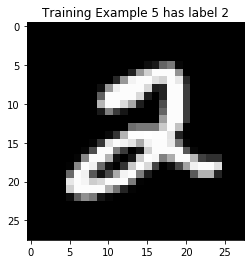

In [0]:
import matplotlib.pyplot as plt
# this next line is just Jupyter Notebook magic to plot inline in the webpage...
%matplotlib inline 

exemplar_index = 5

plt.imshow(x_train[exemplar_index], cmap='gray')
plt.title(f"Training Example {exemplar_index} has label {y_train[exemplar_index]}");

You can change the value of variable `exemplar_index` above and re-run the cell to see the data in the training set and its associated ground truth label.

With MNIST, the examples are stored in a simple file format of pixels, where 0 means background and 255 means foreground. We're next going to scale our input to be in the range of 0.0 to 1.0 by dividing by 255.

This achieves two things - it takes our precision from integer to 32-bit float, and it also scales our input data so that our default learning rate (and other hyperparameters) will work well.  This step is not necessary, but it does help speed things up.

Remember, if you do pre-scaling like this on your training data, you must perform the same steps to any data prior to attempting prediction on it. 

In [0]:
x_train, x_test, x_val = x_train/255.0, x_test / 255.0, x_val / 255.0

In [0]:
# reshape to be [samples][width][height][channel] - Needed for CNN
x_train = x_train.reshape(-1, 28, 28, 1)
x_val = x_val.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [0]:
x_train.shape, x_test.shape, x_val.shape

((60000, 28, 28, 1), (5000, 28, 28, 1), (5000, 28, 28, 1))

## Creating and Configuring our Model

We're create a few variables that can be used to store important model parameters and hyper parameters for modification layer on.

In [0]:
num_epochs = 25  # 5, 10, 25, 35, 100
dropout_rate = 0.25  # 0.1, 0.2, 0.3
batch_size = 16

Now, we will create our fully connected neural network model. This isn't a convolutional model, but a fully connected model, and as you'll see it is quite simple - with only a few layers, and approximately 100,000 trainable parameters. 


In [0]:
# Define neural network:
model = tf.keras.models.Sequential()
print("Input data shape", x_train.shape[1:])

# Input Convolution Layer
model.add(tf.keras.layers.Conv2D(16, (3, 3), input_shape=(28, 28, 1), activation='relu'))

# Second Convolution Layer
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu'))

# Max Pooling
model.add(tf.keras.layers.MaxPooling2D(pool_size = (2, 2)))

# Dropout layer (randomly dropping weights to reduce overfitting)
model.add(tf.keras.layers.Dropout(dropout_rate))

# Flatten from matrix to array for input to fully connected layers
model.add(tf.keras.layers.Flatten())

# Insert fully connected layers here
model.add(tf.keras.layers.Dense(units = 64, activation = 'relu'))
model.add(tf.keras.layers.Dropout(dropout_rate))

# Define Fully Connected Output Layer
model.add(tf.keras.layers.Dense(units = 10, activation = 'softmax'))

Input data shape (28, 28, 1)


You can find out more about the types of layers supported in the Keras API at https://keras.io/layers/core/

Let's have a quick look at the model we just created...

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                294976    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0

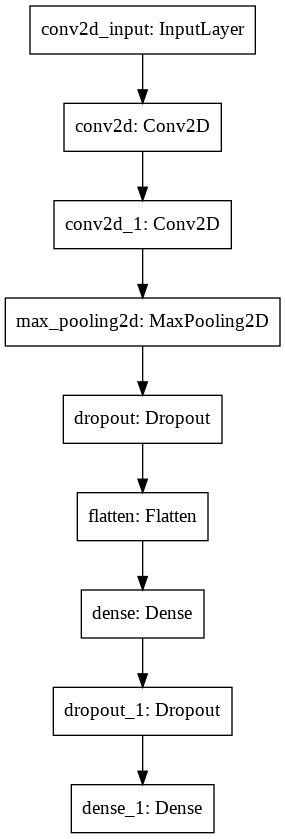

In [0]:
print(model.summary(), '\n')

tf.keras.utils.plot_model(model)


## Training our Model

Okay, now time to compile the model, and to training it.

Compiling, in Keras, configures the model for training - it defines the loss function, the optimizer and metrics. 

It doesn't affect or modify the weights, and you can compile a model as often as you want without affecting pretrained weights.


In [0]:
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(optimizer= opt,
              loss='sparse_categorical_crossentropy', # for integer labels
              metrics=['accuracy'])


Just before we training our model ("fit" it to our data), it will be initialised with random weights. Let's see how it performs against our training data *before* we train it...

In [0]:
model.evaluate(x_train,  y_train, verbose=2)

60000/1 - 6s - loss: 2.2999 - accuracy: 0.1009


[2.30298559773763, 0.10085]

Not terribly impressive - but that is just from random weight assigments. Let's now optimize our weights to improve our prediction score against our training data and see what happens.

In [0]:
# Learning rate scheduler
annealer = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

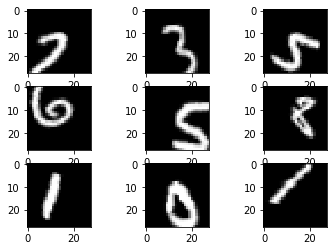

In [0]:
# Define Image Data Generator
# the ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data.
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
		                                                            zoom_range=0.15,
		                                                            width_shift_range=0.2,
		                                                            height_shift_range=0.2,
		                                                            shear_range=0.15,
		                                                            horizontal_flip=True,
		                                                            fill_mode="nearest")
# # Define Image Data Generator for test data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

# Fit parameters from data
train_datagen.fit(x_train)
test_datagen.fit(x_test)


# configure batch size and retrieve one batch of images
for X_batch, y_batch in train_datagen.flow(x_train, y_train, batch_size=9):
    # create a grid of 3x3 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    # show the plot
    plt.show()
    break


In [0]:
# Fit the model on batches and evaluate
training_set = train_datagen.flow(x_train, y_train, batch_size = batch_size)

history = model.fit_generator(training_set,
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              epochs=num_epochs,
                              validation_data=(x_val, y_val),
                              callbacks=[annealer],
                              use_multiprocessing=True)

Epoch 1/25
3750/3750 [==============================] - 128s 34ms/step - loss: 0.9958 - accuracy: 0.6545 - val_loss: 0.2566 - val_accuracy: 0.9172
Epoch 2/25
3750/3750 [==============================] - 128s 34ms/step - loss: 0.6110 - accuracy: 0.7987 - val_loss: 0.1692 - val_accuracy: 0.9498
Epoch 3/25
3750/3750 [==============================] - 128s 34ms/step - loss: 0.5052 - accuracy: 0.8373 - val_loss: 0.1244 - val_accuracy: 0.9670
Epoch 4/25
3750/3750 [==============================] - 128s 34ms/step - loss: 0.4419 - accuracy: 0.8592 - val_loss: 0.0972 - val_accuracy: 0.9724
Epoch 5/25
3750/3750 [==============================] - 126s 34ms/step - loss: 0.4050 - accuracy: 0.8707 - val_loss: 0.0918 - val_accuracy: 0.9714
Epoch 6/25
3750/3750 [==============================] - 126s 33ms/step - loss: 0.3736 - accuracy: 0.8810 - val_loss: 0.0876 - val_accuracy: 0.9752
Epoch 7/25
3750/3750 [==============================] - 125s 33ms/step - loss: 0.3507 - accuracy: 0.8905 - val_loss: 0

In the dictionary variable `history`, we have a record of the training and validation set 

In [0]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


# Evaluating the Performance of our Trained Model against our Validation Set

Okay, let's now see how well our trained model works on our validation set.

In [0]:
model.evaluate(x_val,  y_val, verbose=2)

5000/1 - 1s - loss: 0.0755 - accuracy: 0.9818


[0.05701887072082609, 0.9818]

At this point, consider going back and changing the `num_epochs` from 5 to, say, 25 and repeating the exercise.  Does our model look like it is overfitting at any point?

Or changing the `dropout_rate` from 0.2 to, say, 0.1 or 0.3.

## Evaluating the Performance against our Test Set

We reserved our test set to better understand the impact our training and hyper parameter experiments had in generalising to unseen data. We can now evaluate our performance against our test set.

We can evaluate our model against our test set and get a figure for overall accuracy.

In [0]:
model.evaluate(x_test, y_test, verbose=2)

5000/1 - 0s - loss: 0.1636 - accuracy: 0.9686


[0.09571910588145256, 0.9686]


We can also plot our history from training, and view our training curves - that is, the record of our training set accuracy/loss vs our validation set accuracy/loss per epoch.

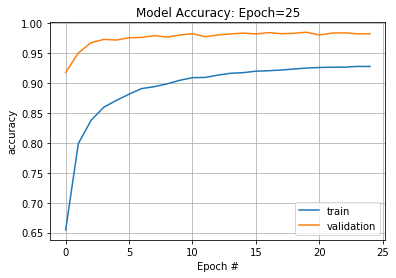

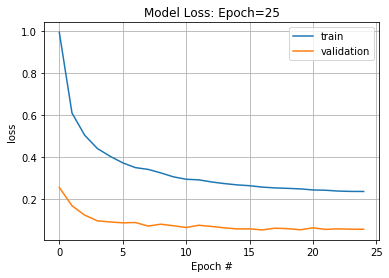

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Model Accuracy: Epoch={num_epochs}')
plt.ylabel('accuracy')
plt.xlabel('Epoch #')
plt.grid()
plt.legend(['train', 'validation'])
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Model Loss: Epoch={num_epochs}')
plt.ylabel('loss')
plt.xlabel('Epoch #')
plt.legend(['train', 'validation'])
plt.grid()
plt.show()

And we can use `model.predict()` to make new predictions for any unseen data from validation/test set.

For item 5, our prediction scores across all classes ("0" through "9") are [5.6137719e-07 9.9993134e-01 4.0814504e-07 9.9352997e-09 5.3800335e-07
 5.5024253e-07 1.7222594e-06 6.4697859e-05 6.7893740e-09 8.8915058e-08]

Our best prediction is 1, and the ground truth is 1.


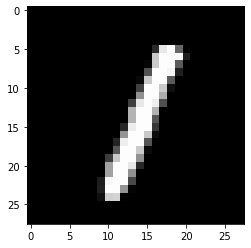

In [0]:
exemplar_index = 5

plt.imshow(x_val[exemplar_index].reshape(28, 28), cmap='gray')

predictions = model.predict(x_val)

print("For item %d, our prediction scores across all classes (\"0\" through \"9\") are %s\n" 
      % (exemplar_index, np.array_str(predictions[exemplar_index])))

#
# We're going to select the column corresponding to the highest prediction
# np.amax picks the highest value in an array, and np.where identifies the column
guess = np.where(predictions[exemplar_index] == np.amax(predictions[exemplar_index]))
# the shape of guess from the previous operation is a 1x1 array, so we need to 
# convert this to a scalar
guess = np.squeeze(guess, axis=(0,1)).item()

print("Our best prediction is %d, and the ground truth is %d." 
      % (guess, y_val[exemplar_index]))

9/1 [==============================================================================================================================================================================================================================================================================] - 0s 10ms/sample


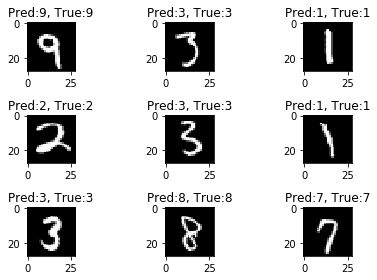

In [0]:
# configure batch size and retrieve one batch of images
for X_batch, y_batch in test_datagen.flow(x_test, y_test, batch_size=9):
    # Get predicted values of each test sample but also convert from 1-hot to the corresponding class'
    # integer representation.
    y_pred_as_integers= model.predict_classes(X_batch, batch_size=9, verbose=1)

    
    # create a grid of 3x3 images
    for i in range(0, 9):
      plt.subplot(330 + 1 + i)
      # create a grid of 3x3 images
      plt.imshow(X_batch[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
      plt.title(f"Pred:{y_pred_as_integers[i]}, True:{y_batch[i]}")
      # if(y_pred_as_integers[i] == y_batch[i]):
      #     print("Correct")
      # else:
      #   print("Incorrect")
    # show the plot
    plt.tight_layout()
    plt.show()

    break



# Experiments 

1. If you haven't already, try changing `num_epochs` above from 5 to, say, 25 and re-training and re-evaluating.  Can you see the different in accuracy for training for longer? Does our model look like it is overfitting at any point?

2. Try changing the `dropout_rate` from 0.2 to, say, 0.1 or 0.3. What is the effect?

3. Try commenting out the dropout layer entirely from our model definition above, and re-running. Can you see the impact of the dropout layer in our performance on the test data? 


    # tf.keras.layers.Dropout(dropout_rate, name="dropout"), # we'll add some dropout

4. Try scanning some of your own handwriting for a digit, and storing it as 28x28 pixel image. Then load the image, and perform a prediction on it. The following code will allow you to upload it to Colab and run a prediction on it... (**Note:** somethings `file.upload()` method can be flakey - if you get an error along the lines of `MessageError: TypeError: Cannot read property '_uploadFiles' of undefined`, run the following cell again...)



Saving num8.png to num8 (1).png
Our prediction scores across all classes ("0" through "9") are [6.8435211e-06 8.4495207e-20 8.5674845e-05 5.0247784e-10 8.2987207e-11
 3.7445683e-10 3.8521284e-06 1.2110450e-18 9.9990356e-01 6.4754446e-09]

Our best prediction is 8


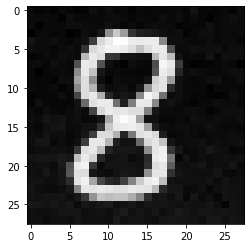

In [0]:
# upload an image file
from google.colab import files

uploaded_image = None

uploaded_image = files.upload()

import io
import cv2

if (uploaded_image != {}):
  # convert the uploaded image data into an OpenCV grayscale inverted image,
  # 28x28, as used by the MNIST data
  image_stream = io.BytesIO(uploaded_image[list(uploaded_image.keys())[0]])                        
  image = cv2.imdecode(np.frombuffer(image_stream.read(), np.uint8),1)
  image = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
  image = cv2.bitwise_not(image) # invert image
  image = cv2.resize(image, (28,28))

  plt.imshow(image, cmap='gray')

  # now, we're rescale our image from 0-255 to 0.0-1.0, and reshape it as an
  # array for input into model.predict
  model_input = image/255.0
  model_input = np.reshape(model_input, (1, 28, 28, 1))
  predictions = model.predict(model_input)

  # finally, we'll print out all our prediction scores and
  # our best guess for the digit
  print("Our prediction scores across all classes (\"0\" through \"9\") are %s\n" 
      % (np.array_str(predictions[0])))
  guess = np.where(predictions[0] == np.amax(predictions[0]))
  guess = np.squeeze(guess, axis=(0,1)).item()
  print("Our best prediction is %d" % (guess))
else:
  print("An image was not successfully uploaded - try again!")